# MultiTool Caller Agent

In [2]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper

In [3]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=5, doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [4]:
arxiv.invoke("Multi-Modal Audio Visual Language Models")

'Published: 2025-03-30\nTitle: TouchUp-G: Improving Feature Representation through Graph-Centric Finetuning\nAuthors: Jing Zhu, Xiang Song, Vassilis N. Ioannidis, Danai Koutra, Christos Faloutsos\nSummary: How can we enhance the node features acquired from Pretrained Models (PMs) to\nbetter suit downstream graph learning tasks? Graph Neural Networks (GNNs) have\nbecome the state-of-the-art approach for many high-impact, real-world graph\napplications. For feature-rich graphs, a prevalent practice invol'

In [5]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
Wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(Wiki.name)

wikipedia


In [6]:
Wiki.invoke("Rick and Morty")

"Page: Rick and Morty\nSummary: Rick and Morty is an American adult animated science fiction sitcom created by Justin Roiland and Dan Harmon for Cartoon Network's nighttime programming block Adult Swim. The series follows the misadventures of Rick Sanchez, a cynical mad scientist, and his good-hearted but fretful grandson Morty Smith, who split their time between domestic life and interdimensional adventures that take place across an infinite number of realities, often traveling to other planets a"

In [7]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LACGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PORJECT"]="ReACT Agent"

In [8]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

/var/folders/x9/7vccwwq12psb87cv4d66wzn00000gn/T/ipykernel_1532/735679136.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [9]:
tavily.invoke("What is GPT-OSS?")

[{'title': "Run OpenAI's new GPT-OSS (open-source) model on ...",
  'url': 'https://northflank.com/blog/self-host-openai-gpt-oss-120b-open-source-chatgpt',
  'content': "Unlike GPT-3.5 or GPT-4, which are closed-source and API-only, GPT-OSS is available to run locally or in your own infrastructure. That means full control over latency, cost, and privacy, especially when paired with a secure, GPU-ready platform like Northflank.\n\nSelf-hosting gpt-oss also means you won’t run into any rate limits. According to OpenAI, gpt-oss 120B’s performance is on par with o4-mini on most benchmarks, which would make it one of the top open-source models, if not the best. [...] Run OpenAI's new GPT-OSS (open-source) model on Northflank\n==========================================================\n\nAI\n\nOpenAI just released GPT-OSS, its first fully open-source large language model family under an Apache 2.0 license. The release includes two models: gpt-oss-20b and gpt-oss-120b, designed for fast, low-

In [10]:
tools=[arxiv, Wiki, tavily]

In [11]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="Gemma2-9b-It")
llm_with_tools=llm.bind_tools(tools)

In [12]:
from pprint import pprint
from langchain_core.messages import HumanMessage, AIMessage

llm_with_tools.invoke([HumanMessage(content=f"What is WACV?"),]).tool_calls

[{'name': 'wikipedia',
  'args': {'query': 'WACV'},
  'id': '81fyqxn8c',
  'type': 'tool_call'}]

## Chatbot

In [13]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

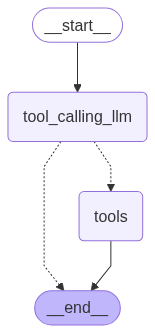

In [14]:
from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

builder=StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)
builder.add_edge("tools", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
messages = graph.invoke({"messages": [HumanMessage(content="Name 8 papers that were selected for WACV 2024?")]})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Name 8 papers that were selected for WACV 2024?
================================== Ai Message ==================================
Tool Calls:
  arxiv (c6026es64)
 Call ID: c6026es64
  Args:
    query: WACV 2024 accepted papers
================================= Tool Message =================================
Name: arxiv

Published: 2025-04-26
Title: ComFace: Facial Representation Learning with Synthetic Data for Comparing Faces
Authors: Yusuke Akamatsu, Terumi Umematsu, Hitoshi Imaoka, Shizuko Gomi, Hideo Tsurushima
Summary: Daily monitoring of intra-personal facial changes associated with health and
emotional conditions has great potential to be useful for medical, healthcare,
and emotion recognition fields. However, the approach for capturing
intra-personal facial changes is relatively unexplored due to the di


In [16]:
messages = graph.invoke({"messages": [HumanMessage(content="provide me the names of top 5 Audio Visual Language Models in 2025")]})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

provide me the names of top 5 Audio Visual Language Models in 2025
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fvfhxgje1)
 Call ID: fvfhxgje1
  Args:
    query: top 5 audio visual language models 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "The best large language models (LLMs) in 2025", "url": "https://zapier.com/blog/best-llm/", "content": "Google Gemini is a family of AI models from Google. The main models—Gemini 2.5 Pro, Gemini 2.5 Flash, Gemini 2.0 Flash, Gemini 1.0 Ultra, Gemini 1.5 Pro, Gemini 1.5 Flash, Gemini 1.0 Nano, and Gemini 1.0 Ultra—are designed to operate on different devices, from smartphones to dedicated servers, and cover a wide variety of uses. [...] Parameters: 1 billion, 3 billion, 8 billion, 11 billion, 70 billion, 90 

## ReACT Agent Architecture

In [17]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper

In [18]:
#custom functions
def multiply(a: int, b: int) -> int:
    """
    Multiplies a and b
    Args:
        a (int): The first number.
        b (int): The second number.
    """
    return a * b

def add(a: int, b: int) -> int: 
    """
    Adds a and b
    Args:
        a (int): The first number.
        b (int): The second number.
    """
    return a + b

def divide(a: int, b: int) -> int:
    """
    Divides a by b
    Args:
        a (int): The first number.
        b (int): The second number.
    """
    return a / b

tools=[arxiv, Wiki, tavily, add, multiply, divide]

In [19]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="Openai/Gpt-Oss-20b")
llm_with_tools=llm.bind_tools(tools)

In [20]:
from pprint import pprint
from langchain_core.messages import HumanMessage, AIMessage

llm_with_tools.invoke([HumanMessage(content=f"name the venue of NeurIPS 2026"),])

AIMessage(content='', additional_kwargs={'reasoning_content': 'The user asks: "name the venue of NeurIPS 2026". We need to provide the name of the venue for NeurIPS 2026. NeurIPS is the conference NeurIPS (Neural Information Processing Systems). We need to know the venue for the 2026 conference. That would be something like "Vienna, Austria" or "Barcelona, Spain"? Let\'s recall: NeurIPS 2025 was held in Vancouver, Canada? Wait, NeurIPS 2024 was in Vancouver, Canada. NeurIPS 2025? I\'m not sure. Let\'s search.', 'tool_calls': [{'id': 'fc_7f114067-6f48-4012-afb9-d9a951dd1bfa', 'function': {'arguments': '{"search_query":"NeurIPS 2026 venue"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 158, 'prompt_tokens': 390, 'total_tokens': 548, 'completion_time': 0.133293851, 'prompt_time': 0.02458153, 'queue_time': 0.04530407, 'total_time': 0.157875381}, 'model_name': 'Openai/Gpt-Oss-20b', 'system_fingerprint': 'fp_fd68d84dd3

In [21]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

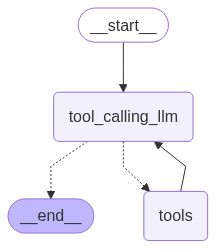

In [22]:
from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

builder=StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me a step by step guide on how to build a Computer Vision project from scratch from an article from freecodecamp.org, what is 2 plus 4 multiplied by 8 then divided by 3?")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Provide me a step by step guide on how to build a Computer Vision project from scratch from an article from freecodecamp.org, what is 2 plus 4 multiplied by 8 then divided by 3?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fc_63febc86-de84-465b-b37e-fc8cda283009)
 Call ID: fc_63febc86-de84-465b-b37e-fc8cda283009
  Args:
    query: freecodecamp computer vision project from scratch
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Advanced Computer Vision with Python - freeCodeCamp", "url": "https://www.freecodecamp.org/news/advanced-computer-vision-with-python/", "content": "In the second half of the course you will create five projects with real-word application. Here is what you will create:\n\nWatch the full course below or on the freeCodeCamp.org You

## Agent Memory

#### MemorySaver

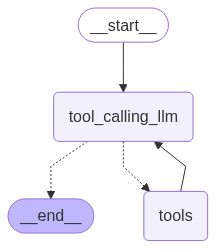

In [24]:
from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

builder=StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")

from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

display(Image(graph_memory.get_graph().draw_mermaid_png()))

In [27]:
config={"configurable":{"thread_id":"1"}}

messages=[HumanMessage(content="Add 12 and 13.")]
messages=graph.invoke({"messages":messages},config=config)
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (fc_c30b7e2b-64d3-4c53-8227-17f99fa7a7f0)
 Call ID: fc_c30b7e2b-64d3-4c53-8227-17f99fa7a7f0
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

25


In [28]:
messages=[HumanMessage(content="Divide that number by 5.")]
messages=graph.invoke({"messages":messages},config=config)
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Divide that number by 5.
================================== Ai Message ==================================

Sure!  
\( \dfrac{1200}{5} = 240 \).


## Streaming

In [32]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

def superbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}
#graph_memory = builder.compile(checkpointer=memory)

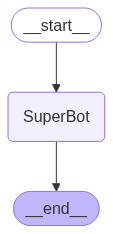

In [34]:
graph = StateGraph(State)

graph.add_node("SuperBot",superbot)

graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)

graph_builder=graph.compile(checkpointer=memory)

display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [35]:
config={"configurable":{"thread_id":"2"}}
graph_builder.invoke({"messages":"Yo! I'm Jyo. I like momos"},config=config)

{'messages': [HumanMessage(content="Yo! I'm Jyo. I like momos", additional_kwargs={}, response_metadata={}, id='bcb42089-8c79-43ee-b131-dee0e5b05a90'),
  AIMessage(content='Hey Jyo! 👋 Momos are amazing—do you have a favorite filling or a go‑to momo spot? I’d love to hear about it!', additional_kwargs={'reasoning_content': 'User says "Yo! I\'m Jyo. I like momos". This is a casual greeting. We should respond conversationally, maybe ask about momos. Also note user didn\'t ask a question. We should respond in a friendly tone, maybe mention momos.'}, response_metadata={'token_usage': {'completion_tokens': 96, 'prompt_tokens': 81, 'total_tokens': 177, 'completion_time': 0.079742195, 'prompt_time': 0.006469203, 'queue_time': 0.065041586, 'total_time': 0.086211398}, 'model_name': 'Openai/Gpt-Oss-20b', 'system_fingerprint': 'fp_fd68d84dd3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--32b39d9a-fdfa-497d-9844-6a420260468a-0', usage_metadata={'input_tokens': 8

In [39]:
config={"configurable":{"thread_id":"2"}}

for chunk in graph_builder.stream({"messages":"Yo! I'm Jyo. I like momos"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content='Hey Jyo! 👋\n\nYou’ve got a “momo‑mania” vibe going on—love it! 🎉 Whether you’re craving the classic steamed veg, the spicy chicken, or a wild fusion (think *momo pizza* 🥟🍕), I’m here to keep it rolling.  \n\n**Quick idea to spice things up:**\n\n> **Momo‑Bowl**  \n> 1. Steam a batch of your favorite momos.  \n> 2. Toss them with a drizzle of soy‑ginger sauce.  \n> 3. Sprinkle chopped cilantro, fried onions, and a dash of chili oil.  \n> 4. Top with a poached egg (optional).  \n> 5. Serve hot—boom, instant comfort food!\n\nIf you’re in the mood to explore beyond the kitchen, just let me know your city or a craving you’re feeling, and I’ll hit you up with a top‑rated spot or a DIY hack. 🚀\n\nWhat’s your current momo mood? 🌶️🥟', additional_kwargs={'reasoning_content': "User repeats same phrase. Likely wants something. They might be testing. We should respond creatively, maybe ask a question, or give a meme. Let's give a playful response."}, re

In [40]:
for chunk in graph_builder.stream({"messages":"Yo! I'm Jyo. I like momos"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content="Yo! I'm Jyo. I like momos", additional_kwargs={}, response_metadata={}, id='bcb42089-8c79-43ee-b131-dee0e5b05a90'), AIMessage(content='Hey Jyo! 👋 Momos are amazing—do you have a favorite filling or a go‑to momo spot? I’d love to hear about it!', additional_kwargs={'reasoning_content': 'User says "Yo! I\'m Jyo. I like momos". This is a casual greeting. We should respond conversationally, maybe ask about momos. Also note user didn\'t ask a question. We should respond in a friendly tone, maybe mention momos.'}, response_metadata={'token_usage': {'completion_tokens': 96, 'prompt_tokens': 81, 'total_tokens': 177, 'completion_time': 0.079742195, 'prompt_time': 0.006469203, 'queue_time': 0.065041586, 'total_time': 0.086211398}, 'model_name': 'Openai/Gpt-Oss-20b', 'system_fingerprint': 'fp_fd68d84dd3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--32b39d9a-fdfa-497d-9844-6a420260468a-0', usage_metadata={'input_tokens': 81,

In [41]:
for chunk in graph_builder.invoke({"messages":"I also like Football, Gym and Cycling"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content='Hey Jyo! 👋  \nSounds like you’ve got a solid mix of passions—momos, football, gym, and cycling. That’s a great combo for staying energized and having fun!\n\n### 1️⃣ Momos  \n- **Quick Fix**: If you’re craving a quick bite after a workout or a long ride, try steaming a batch of veggie momos and pair them with a spicy **green chutney**.  \n- **Gym‑Fuel**: Add a side of **protein‑packed** chicken or tofu filling for a post‑gym boost.\n\n### 2️⃣ Football  \n- **What’s your favorite side?**  \n  - ⚽️ Soccer (football)  \n  - 🏈 American football  \n  - 🎽 Rugby (just in case you’re into that too)\n\nFeel free to tell me which one you’re into, and I can drop some quick drills, strategy tips, or match‑night playlists for you.\n\n### 3️⃣ Gym  \n- **Quick 20‑Minute Circuit** (no equipment needed):\n  1. **Jump Squats** – 3\u202f×\u202f15  \n  2. **Push‑ups** – 3\u202f×\u202f12 (modify on knees if needed)  \n  3. **Mountain Climbers** – 3\u202f×\u202f

In [42]:
for chunk in graph_builder.stream({"messages":"I am from NE India"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content="Yo! I'm Jyo. I like momos", additional_kwargs={}, response_metadata={}, id='bcb42089-8c79-43ee-b131-dee0e5b05a90'), AIMessage(content='Hey Jyo! 👋 Momos are amazing—do you have a favorite filling or a go‑to momo spot? I’d love to hear about it!', additional_kwargs={'reasoning_content': 'User says "Yo! I\'m Jyo. I like momos". This is a casual greeting. We should respond conversationally, maybe ask about momos. Also note user didn\'t ask a question. We should respond in a friendly tone, maybe mention momos.'}, response_metadata={'token_usage': {'completion_tokens': 96, 'prompt_tokens': 81, 'total_tokens': 177, 'completion_time': 0.079742195, 'prompt_time': 0.006469203, 'queue_time': 0.065041586, 'total_time': 0.086211398}, 'model_name': 'Openai/Gpt-Oss-20b', 'system_fingerprint': 'fp_fd68d84dd3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--32b39d9a-fdfa-497d-9844-6a420260468a-0', usage_metadata={'input_tokens': 81,

In [44]:
config={"configurable":{"thread_id":"5"}}

async for event in graph_builder.astream_events({"messages":"Yo! I'm Jyo from NE India"}, config,version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': "Yo! I'm Jyo from NE India"}}, 'name': 'LangGraph', 'tags': [], 'run_id': '4537fe61-d68c-40e4-936c-92f39bb3b5e7', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content="Yo! I'm Jyo from NE India", additional_kwargs={}, response_metadata={}, id='c8b0b882-9cbf-4710-87b3-404b05d56896')]}}, 'name': 'SuperBot', 'tags': ['graph:step:1'], 'run_id': 'f473e415-6f9e-4426-9980-e80ce2279fe1', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:4bd93469-0676-0e5e-3601-a8607f60145c'}, 'parent_ids': ['4537fe61-d68c-40e4-936c-92f39bb3b5e7']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content="Yo! I'm Jyo from NE India", additional_kwargs={}, response_metadata={}, id='c8b0b

## Debugging using LangGraph Studio